In [1]:
model_name= 'scibert_cls_static'

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys 
sys.path.append('../')

In [4]:
import os
import tensorflow 
import numpy as np
import random

seed_value = 42
#seed_value = None

environment_name = sys.executable.split('/')[-3]
print('Environment:', environment_name)
os.environ[environment_name] = str(seed_value)


np.random.seed(seed_value)
random.seed(seed_value)
tensorflow.random.set_seed(seed_value)

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
import tensorflow.compat.v1.keras.backend as K
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
K.set_session(session)

tensorflow.__version__

Environment: biotmpygpu


'2.2.0'

In [5]:
multiple_gpus = [0,1,2,3]
#multiple_gpus = None

In [6]:
import os
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

if multiple_gpus:
    devices = []
    for gpu in multiple_gpus:
        devices.append('/gpu:' + str(gpu))    
    strategy = tensorflow.distribute.MirroredStrategy(devices=devices)
    os.environ["CUDA_VISIBLE_DEVICES"] = ''

else:
    # Get the GPU device name.
    device_name = tensorflow.test.gpu_device_name()
    # The device name should look like the following:
    if device_name == '/device:GPU:0':
        print('Using GPU: {}'.format(device_name))
    else:
        raise SystemError('GPU device not found')

    os.environ["CUDA_VISIBLE_DEVICES"] = device_name
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"

Num GPUs Available:  4
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


In [7]:
from wrappers.bioc_wrapper import bioc_to_docs, bioc_to_relevances
from wrappers.pandas_wrapper import relevances_to_pandas, docs_to_pandasdocs
from preprocessing.dl import DL_preprocessing
from mlearning.dl_models import Bert_Dense, Bert_LSTM, Bert_CLS, Bert_Sequence
from mlearning.dl import Bert_preprocessing
from preprocessing.embeddings import compute_embedding_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import matthews_corrcoef, cohen_kappa_score
from sklearn.metrics import roc_auc_score, auc, roc_curve, precision_recall_curve
from sklearn.metrics import confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from preprocessing.config import Config
from preprocessing.dl import average_precision
from preprocessing.dl import plot_roc_n_pr_curves, plot_training_history
from transformers import BertTokenizer
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import stopwords
import pandas as pd
import os
from transformers import AutoTokenizer

[nltk_data] Downloading package stopwords to /home/malves/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/malves/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/malves/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [8]:
train_dataset_path = '../datasets/PMtask_Triage_TrainingSet.xml'
test_dataset_path = '../datasets/PMtask_Triage_TestSet.xml'
output_excel = 'metrics/results_'+ model_name + '.xlsx'

In [9]:
# !wget https://s3-us-west-2.amazonaws.com/ai2-s2-research/scibert/tensorflow_models/scibert_scivocab_uncased.tar.gz
# !tar -xvf ./scibert_scivocab_uncased.tar.gz

In [10]:
# os.environ["WANDB_API_KEY"] = "0" ## to silence warning
# !transformers-cli convert --model_type bert \
#   --tf_checkpoint './scibert_scivocab_uncased/bert_model.ckpt' \
#   --config './scibert_scivocab_uncased/bert_config.json' \
#   --pytorch_dump_output './scibert_scivocab_uncased/pytorch_model.bin'

## Load Data

In [11]:
config = Config(model_name=model_name, seed_value=seed_value)

#config.stop_words = set(stopwords.words('english'))            #####
config.stop_words = None
config.lower = True                #####
config.remove_punctuation = False
config.split_by_hyphen = False   
config.lemmatization = False           #####
config.stems = False                       #####


docs_train = bioc_to_docs(train_dataset_path, config=config)
relevances_train = bioc_to_relevances(train_dataset_path, 'protein-protein')


x_train_df = docs_to_pandasdocs(docs_train)
y_train_df = relevances_to_pandas(x_train_df, relevances_train)

In [12]:
x_train_df

,Document
9685346,<data_structures.document.Document object at 0...
10364224,<data_structures.document.Document object at 0...
10688642,<data_structures.document.Document object at 0...
12059041,<data_structures.document.Document object at 0...
12897151,<data_structures.document.Document object at 0...
...,...
22521144,<data_structures.document.Document object at 0...
25759389,<data_structures.document.Document object at 0...
19887646,<data_structures.document.Document object at 0...
23486661,<data_structures.document.Document object at 0...


In [13]:
y_train_df

9685346     0
10364224    0
10688642    0
12059041    0
12897151    0
           ..
22521144    1
25759389    1
19887646    1
23486661    1
22992732    1
Name: Label, Length: 4082, dtype: int64

In [14]:
x_train_df['Document'][0].title_string

'the molecular basis of rieger syndrome analysis of pitx2 homeodomain protein activities rieger syndrome is an autosomal-dominant developmental disorder that includes glaucoma and mild craniofacial dysmorphism in humans'

In [15]:
x_train_df['Document'][0].abstract_string

'mutations in the pitx2 homeobox gene have been linked to rieger syndrome we have characterized wild type and mutant pitx2 activities using electrophoretic mobility shift assays protein binding and transient transfection assays pitx2 preferentially binds the bicoid homeodomain binding site and transactivates reporter genes containing this site the combination of pitx2 and another homeodomain protein pit-1 yielded a synergistic 55-fold activation of the prolactin promoter in transfection assays addition of pit-1 increased pitx2 binding to the bicoid element in electrophoretic mobility shift assays furthermore we demonstrate specific binding of pit-1 to pitx2 in vitro thus wild type pitx2 dna binding activity is modulated by protein-protein interactions we next studied two rieger mutants a threonine to proline mutation t68p in the second helix of the homeodomain retained dna binding activity with the same apparent kd and only about a 2-fold reduction in the bmax however this mutant did n

### Deep Learning

In [16]:
#Parameters
config.padding = 'post'           
config.truncating = 'post'        

config.epochs = 8         # recommended number of epochs: 2, 3, 4 
config.batch_size = 32     # recommended batch-size: 16 or 32  # 8, 16, 32, 64, 128
config.learning_rate = 1e-3   # recommended learning rate for Adam: 5e-5, 3e-5, 2e-5   # 3e-4, 1e-4,

config.max_sent_len = 512      #sentences will have a maximum of "max_sent_len" words
config.nmr_sentences = 1    #[1 or 2]

config.validation_percentage = 10

### Keras Callbacks

In [17]:
config.keras_callbacks = False

if config.keras_callbacks:
    config.patience = 10   #early-stopping patience
    checkpoint_path = str(config.model_id_path) + '/checkpoint.hdf5'
    keras_callbacks = [
            EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=config.patience),
            ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)
    ]
else:
    keras_callbacks=None

## SciBert

In [18]:
config.tokenizer = BertTokenizer.from_pretrained('./scibert_scivocab_uncased', do_lower_case=True)

In [19]:
list(config.tokenizer.vocab.keys())[3000:3020]

['#',
 '##atin',
 'usually',
 'investigated',
 '##mic',
 'rout',
 'scen',
 'improved',
 'just',
 'criteria',
 '##7;',
 '##9;',
 '(3)',
 'generally',
 'generation',
 'emerg',
 'interesting',
 'contains',
 'failure',
 'ieee']

In [20]:
x_train, y_train, x_val, y_val =  Bert_preprocessing(x_train_df, y_train_df, 
                                                     config, 
                                                     nmr_sentences = config.nmr_sentences, 
                                                     validation_percentage = config.validation_percentage, 
                                                     seed_value=config.seed_value)

Training set with 3674 samples
Validation set with 408 samples


In [26]:
c=0
for doc in x_train_df['Document']:
    marked_text = "[CLS] " + doc.fulltext_string + " [SEP]"
    x = config.tokenizer.tokenize(marked_text)
    if len(x) > 512:
        c+=1
        print(c)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35


In [21]:
from mlearning.dl_models import Bert_Dense_opt, Bert_CLS_opt, Bert_LSTM_opt
scibert_path = './scibert_scivocab_uncased'

if multiple_gpus:
    with strategy.scope():
        model = Bert_LSTM_opt(config, learning_rate=config.learning_rate, static_bert=True, bert_name_or_path=scibert_path, bert_config=True)
        #model = Bert_FE(config, learning_rate=config.learning_rate, bert_name_or_path=scibert_path, bert_config=True)
        #model = Bert_Sequence_FT(config, learning_rate=config.learning_rate, bert_name_or_path=scibert_path, bert_config=True)
        #model = Bert_Sequence_FE(config, learning_rate=config.learning_rate, bert_name_or_path=scibert_path, bert_config=True)
        
else:
    model = Bert_LSTM_opt(config, learning_rate=config.learning_rate, static_bert=True, bert_name_or_path=scibert_path, bert_config=True)
    #model = Bert_FE(config, learning_rate=config.learning_rate, bert_name_or_path=scibert_path, bert_config=True)
    #model = Bert_Sequence_FT(config, learning_rate=config.learning_rate, bert_name_or_path=scibert_path, bert_config=True)
    #model = Bert_Sequence_FE(config, learning_rate=config.learning_rate, bert_name_or_path=scibert_path, bert_config=True)

All PyTorch model weights were used when initializing TFBertModel.

Some weights or buffers of the PyTorch model TFBertModel were not initialized from the TF 2.0 model and are newly initialized: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'bert.embeddings.position_ids', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_idx (InputLayer)          [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_segments (InputLayer)     [(None, 512)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     ((None, 512, 768), ( 109918464   input_idx[0][0]                  
                                                                 input_masks[0][0]            

In [22]:
history = model.fit(x_train, y_train,
                    epochs=config.epochs,
                    batch_size=config.batch_size,
                    validation_data=(x_val, y_val),
                    callbacks=keras_callbacks)

if config.keras_callbacks:
    model.load_weights(checkpoint_path)

Epoch 1/8
INFO:tensorflow:batch_all_reduce: 10 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 10 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/ta

## Evaluation

In [23]:
#train_loss, config.train_acc = model.evaluate(x_train, y_train, verbose=0)

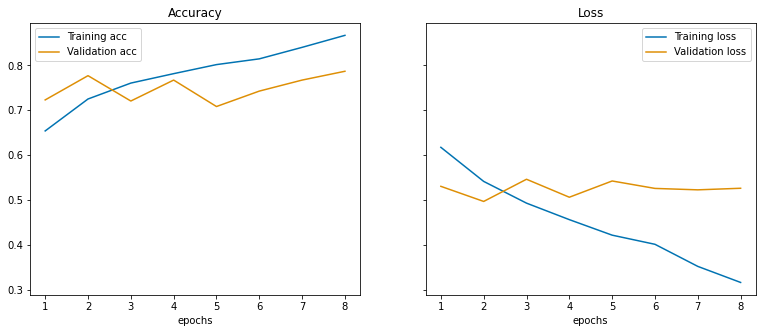

In [24]:
#print('Training Loss: %.3f' % (train_loss))
#print('Training Accuracy: %.3f' % (config.train_acc))

plot_training_history(history_dict = history, config=config)

# Test Set

### Load Data

In [25]:
docs_test = bioc_to_docs(test_dataset_path, config=config)
relevances_test = bioc_to_relevances(test_dataset_path, 'protein-protein')

x_test_df = docs_to_pandasdocs(docs_test)
y_test_df = relevances_to_pandas(x_test_df, relevances_test)

### Preprocessing

In [26]:
x_test, y_test = Bert_preprocessing(x_test_df, y_test_df, config,
                                    nmr_sentences=config.nmr_sentences)

### Predictions

In [27]:
yhat_probs = model.predict(x_test, verbose=0)
yhat_probs = yhat_probs[:, 0]

yhat_classes = np.where(yhat_probs > 0.5, 1, yhat_probs)
yhat_classes = np.where(yhat_classes < 0.5, 0, yhat_classes).astype(np.int64)

### Evaluation

### ROC and Precision-Recall Curves

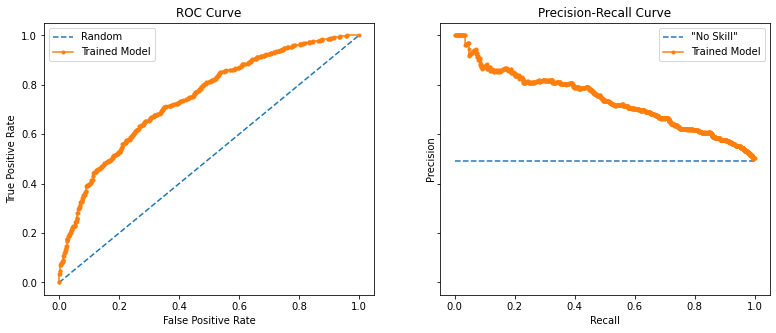

In [28]:
config.test_roc_auc, config.test_pr_auc = plot_roc_n_pr_curves(y_test, yhat_probs,config = config)

In [29]:
config.test_avg_prec  = average_precision(y_test_df, yhat_probs)
print('Average Precision: %f' % config.test_avg_prec)

# accuracy: (tp + tn) / (p + n)
config.test_acc = accuracy_score(y_test, yhat_classes)
print('Accuracy: %f' % config.test_acc)

# precision tp / (tp + fp)
config.test_prec = precision_score(y_test, yhat_classes)
print('Precision: %f' % config.test_prec)

# recall: tp / (tp + fn)
config.test_recall = recall_score(y_test, yhat_classes)
print('Recall: %f' % config.test_recall)

# f1: 2 tp / (2 tp + fp + fn)
config.test_f1_score = f1_score(y_test, yhat_classes)
print('F1 score: %f' % config.test_f1_score)

# ROC AUC
print('ROC AUC: %f' % config.test_roc_auc)

# PR AUC
print('PR AUC: %f' % config.test_pr_auc)

# kappa
config.test_kappa = cohen_kappa_score(y_test, yhat_classes)
print('Cohens kappa: %f' % config.test_kappa)

config.test_mcc = matthews_corrcoef(y_test, yhat_classes)
print('MCC: %f' % config.test_mcc)

# confusion matrix
matrix = confusion_matrix(y_test, yhat_classes)
print('Confusion Matrix:\n %s \n' % matrix)

config.test_true_neg, config.test_false_pos, config.test_false_neg, config.test_true_pos = confusion_matrix(
                                                                                                y_test, yhat_classes).ravel()

Average Precision: 0.738788
Accuracy: 0.659425
Precision: 0.631643
Recall: 0.742898
F1 score: 0.682768
ROC AUC: 0.744249
PR AUC: 0.738467
Cohens kappa: 0.320303
MCC: 0.325231
Confusion Matrix:
 [[418 305]
 [181 523]] 



## Model ID

In [30]:
config.model_id

'scibert_cls_static_2'

## Save config

In [31]:
config.save()

In [32]:
config.path

PosixPath('../pipelines/models/scibert_cls_static/scibert_cls_static_2/config.txt')

## Write Results

In [33]:
config.write_report()

{'model_id': ['scibert_cls_static_2'], 'max_sent_len': [512], 'max_nb_words': [None], 'max_nb_sentences': [None], 'nmr_sentences': ['True'], 'embeddings': [None], 'embedding_dim': [None], 'embedding_format': [None], 'stop_words': ['No'], 'padding': ['post'], 'truncating': ['post'], 'oov_token': [None], 'lower': ['True'], 'remove_punctuation': ['False'], 'split_by_hyphen': ['False'], 'lemmatization': ['False'], 'stems': ['False'], 'seed_value': [42], 'epochs': [8], 'batch_size': [32], 'learning_rate': [0.001], 'validation_percentage': [10], 'patience': [None], 'keras_callbacks': ['False'], 'train_acc': [None], 'train_f1_score': [None], 'test_avg_prec': [0.738787751104962], 'test_acc': [0.6594253679046952], 'test_prec': [0.6316425120772947], 'test_recall': [0.7428977272727273], 'test_f1_score': [0.6827676240208876], 'test_roc_auc': [0.7442494184584434], 'test_pr_auc': [0.7384668178821332], 'test_kappa': [0.32030303624282097], 'test_mcc': [0.3252309850199495], 'test_true_neg': [418], 'tes

### Model Save

In [ ]:
model.save(config.model_id_path / 'model_tf', save_format = 'tf')

In [ ]:
from IPython.lib.display import Audio
import numpy as np

framerate = 4410
play_time_seconds = 1

t = np.linspace(0, play_time_seconds, framerate*play_time_seconds)
audio_data = np.sin(2*np.pi*300*t) + np.sin(2*np.pi*240*t)
Audio(audio_data, rate=framerate, autoplay=True)